In [2]:
import numpy as np # 快速操作结构数组的工具
import matplotlib.pyplot as plt  # 可视化绘制
from sklearn.linear_model import LinearRegression  # 线性回归
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.preprocessing import OneHotEncoder

# 1.构造数据集

In [3]:
X, y = make_classification(n_samples=80000,n_features=20,n_classes=2)

# 2.数据集分割与estimator准备

In [4]:
# 切分为测试集和训练集，比例0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
# 将训练集切分为两部分，一部分用于训练GBDT模型，另一部分输入到训练好的GBDT模型生成GBDT特征，然后作为LR的特征。这样分成两部分是为了防止过拟合。
X_train_gbdt, X_train_lr, y_train_gbdt, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)
# 调用GBDT分类模型。
n_estimator = 10
gbdt = GradientBoostingClassifier(n_estimators=n_estimator)
# 调用one-hot编码。
one_hot = OneHotEncoder()
# 调用LR分类模型。
lr = LogisticRegression()

# 3. 使用X_train训练GBDT模型，后面用此模型构造特征
1. 将数据集划分成两部分，一份训练GBDT，一份用GBDT生成特征
2. 生成新特征的过程：
> 1. x_leaf_index = gbdt.apply(X_train_gbdt)[:,:,0]----->得到每个样本在每个树中所属的叶子索引
> 2. x_lr_leaf_index = gbdt.apply(X_train_lr)[:,:,0]
> 3. one_hot.fit(X_leaf_index)
> 4. one_hot.transform(X_lr_leaf_index)------->一个树上的一个叶子节点就为一个新特征，每个样本其上取值为1或0.这样就可以直接用了

In [5]:
gbdt.fit(X_train_gbdt,y_train_gbdt)

# apply返回每个样本在每颗树中所属的叶子节点索引。行数为样本数，列数为树数目。值为在每个树的叶子索引
X_leaf_index = gbdt.apply(X_train_gbdt)[:,:,0]

gbdt1 = gbdt
X_lr_leaf_index = gbdt1.apply(X_train_lr)[:,:,0]
print("每个样本在每个树中所属的叶子索引\n",X_leaf_index)
X_leaf_index.shape

每个样本在每个树中所属的叶子索引
 [[ 7.  6.  7. ...  6.  7.  6.]
 [14. 14. 14. ... 14. 14. 14.]
 [14. 14. 14. ... 14. 14. 14.]
 ...
 [ 7.  6.  7. ...  6.  7.  6.]
 [14. 14. 14. ... 14. 14. 14.]
 [14. 14. 14. ... 14. 14. 14.]]


(20000, 10)

In [5]:
one_hot.fit(X_leaf_index)
X_lr_one_hot = one_hot.transform(X_lr_leaf_index)
# 将训练数据，通过gbdt树，形成的叶子节点（每个叶子代表了原始特征的一种组合）索引，编码成one0-hot特征。
# 编码后的每个特征代表原来的一批特征的组合。
print(X_lr_one_hot.shape)

(20000, 80)


/home/sundali/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# 4.模型效果提升对比
1. 得到每个样本的为1的预测proba:lr.predict(one_hot.transform(gbdt.apply(X_test)[:,:,0))[:,1]
2. 得到fpr,tpr,以及阈值：fpr,tpr,thresholds = roc_curve(真实标签，预测概率）
3. auc值：roc_auc = auc(fpr,tpr)

使用逻辑回归只训练gbdt组合出来的特征的效果
auc值为
 0.9799659294192513


/home/sundali/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


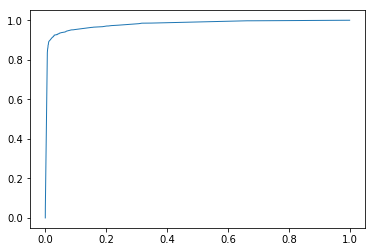

In [11]:
print("使用逻辑回归只训练gbdt组合出来的特征的效果")
lr.fit(X_lr_one_hot,y_train_lr)
# 训练出的lr预测X_test的效果
y_pred_grd_lm = lr.predict_proba(one_hot.transform(gbdt.apply(X_test)[:,:,0]))[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_grd_lm)  # 获取真正率和假正率以及门限
roc_auc = auc(fpr, tpr)
print('auc值为\n',roc_auc)
#画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来
plt.plot(fpr, tpr, lw=1, label='area = %0.2f' %  roc_auc)
plt.show()

使用逻辑回归训练原始数据集的结果
(20000, 20)
auc值为
 0.9142133575775552


/home/sundali/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


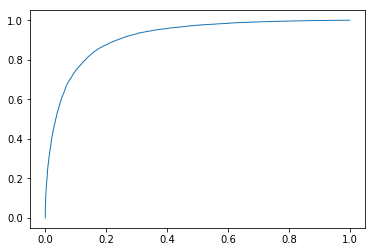

In [16]:
# 使用lr直接训练原始数据
print('使用逻辑回归训练原始数据集的结果')
lr.fit(X_train_lr, y_train_lr)
print(X_train_lr.shape)
# 用训练好的LR模型多X_test做预测
y_pred_grd_lm = lr.predict_proba(X_test)[:, 1]  # 获取测试集正样本的概率
# 根据预测结果输出
fpr, tpr, thresholds = roc_curve(y_test, y_pred_grd_lm)  # 获取真正率和假正率以及门限
roc_auc = auc(fpr, tpr)
print('auc值为\n',roc_auc)
#画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来
plt.plot(fpr, tpr, lw=1, label='area = %0.2f' %  roc_auc)
plt.show()

In [25]:
# # 使用lr训练原始数据+生成特征
# import pandas as pd
# print('使用逻辑回归训练原始数据集+生成特征的结果')
# x_train_lr1 = (pd.concat([pd.DataFrame(X_train_lr),pd.DataFrame(X_lr_one_hot)],axis = 1)).values
# x_test_lr1 = (pd.concat([pd.DataFrame(X_test),pd.DataFrame(one_hot.transform(gbdt.apply(X_test)[:,:,0]))],axis=1)).values
# # x_test_lr1 = np.hstack((X_test,one_hot.transform(gbdt.apply(X_test)[:,:,0])))
# lr.fit(x_train_lr1, y_train_lr)
# # 用训练好的LR模型多X_test做预测
# y_pred_grd_lm = lr.predict_proba(x_test_lr1)[:, 1]  # 获取测试集正样本的概率
# # 根据预测结果输出
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_grd_lm)  # 获取真正率和假正率以及门限
# roc_auc = auc(fpr, tpr)
# print('auc值为\n',roc_auc)
# #画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来
# plt.plot(fpr, tpr, lw=1, label='area = %0.2f' %  roc_auc)
# plt.show()

# 5.GBDT生成特征函数

In [ ]:
def gbdt_create_features(x_gbdt,y_gbdt,x_other_model,y_other_model,n_estimator = 10):
    """
    利用GBDT训练一部分数据，然后利用另一部分数据用gbdt生成新特征，进行最终模型训练
    A
    """
    def gbdt_feature_combination(gbdt_model,x_other_model,x_gbdt):
    """
    利用GBDT训练一部分数据，然后利用另一部分数据用gbdt生成新特征，进行最终模型训练
    Args:
        gbdt_model:已经训练好的gbdt模型
        x_gbdt:训练gbdt的数据特征数据集
        x_other_model: 将用gbdt生成新特征的数据集
    Returns:
        每个样本在新特征上的one-hot编码

    """

    # apply返回每个样本在每颗树中所属的叶子节点索引。行数为样本数，列数为树数目。值为在每个树的叶子索引
    x_leaf_index = gbdt_model.apply(x_gbdt)[:,:,0]
    x_other_leaf_index = gbdt_model.apply(x_other_model)[:,:0]

    # one-hot编码新生成特征
    one_hot = OneHotEncoder()
    one_hot.fit(x_leaf_index)
    x_other_model_one_hot = one_hot.transform(x_other_leaf_index)

    return x_other_model_one_hot
